# kaggle Titanic の作成コードについて Tips をまとめる。

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## 相関係数の HeatMap

第1引数に、対象とするpandas.DaraFrameを設定、'annot'はヒートマップ上に数値を表示するかどうかのオプション<br>
※ 以下に両方のパターンを記載する。<br>

ほかの引数<br>
- cbar → Falseにすると、カラーバーが非表示になる。
- square → Trueにすると、ヒートマップが正方形で描画される。
- vmax, vmin, center → ヒートマップの最大値・最小値・中央値を指定する。
- cmap → 色(カラーマップ)を指定(matplotlibで使えるカラーマップがそのまま使える。)

In [15]:
pd.read_csv("training_data/train.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


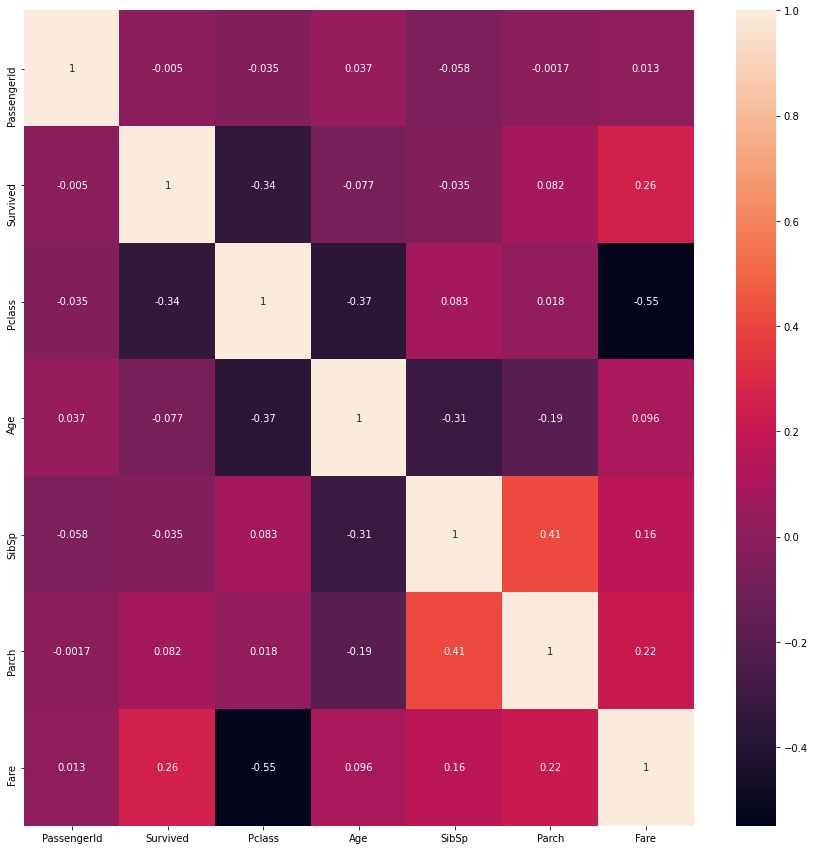

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df.corr(), annot=True)

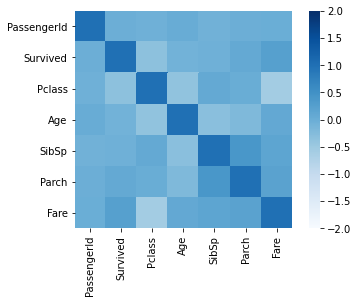

In [14]:
"""
ほかのオプションのチェック
"""
sns.heatmap(train_df.corr(), vmax=2, vmin=-2, center=0, square=True, cmap="Blues")

## 各要素について、正解ラベルごとのプロットを確認
■ seaborn.countplot を使用 <br>
【引数】<br>
- x → カウントしたい対象のデータフレーム(ラベルでOK)
- hue → 傾向を見たい対象のデータフレーム(これもラベルでOK)
- data → もとになるデータフレーム
- palette → カラーリング(matplotlibと同様のAPIが使える？)

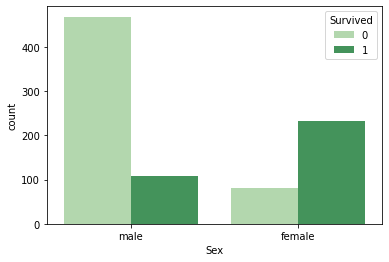

In [21]:
sns.countplot("Sex", hue="Survived", data=train_df, palette="Greens")

## データの分布を推定したいとき
■ seaborn.kdeplot を使用<br>
【引数】<br>
- data → 描画したいデータを投げればOK
- ax → 描画したい axes: matplotlibで色々設定したものを投げられる。特に軸の範囲は調整したい場面が多いはず。

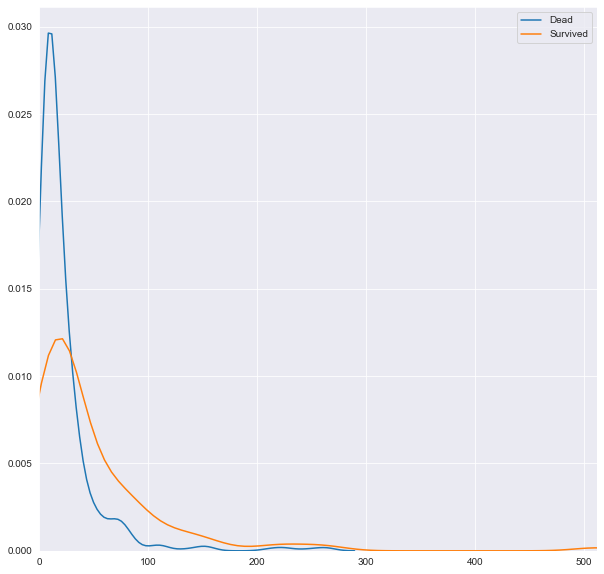

In [34]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim(0, train_df["Fare"].max())

sns.kdeplot(train_df["Fare"][train_df["Survived"]==0], ax=ax)
sns.kdeplot(train_df["Fare"][train_df["Survived"]==1], ax=ax)

ax.legend(["Dead", "Survived"])

plt.show()

# Scikit-learn 関係のTips

## GridSearchCV
ハイパーパラメータチューニングに使用。<br>
【使い方の流れ】<br>
- 最適化したいパラメータをリストで定義する
- 最適化の実行
- 結果の表示

【公式URL】
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

【GridSearchCV の引数】<br>
- estimator: 推定期のオブジェクト sklearn のインターフェースのものをしてする必要あり。
- param_grid: リストまたはディクショナリ。最適化対象の変数名はstr型で記載、パラメータのリストは値のリストとして与える。
- scoring: 評価指標。https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter に記載されているものが使用可能
- n_jobs: CPUのコアをいくつ並列動作させるかを指定する。デフォルトは None。-1を指定すると、使用可能なコアはすべて使用する。 
- iid: Trueならば、foldにわたる平均のスコアをリターンする。
- cv: クロスバリデーションのsplit数を指定する。
- refit: サーチしたベストなパラメータで再度フィッティングを行うか否かのフラグ。デフォルトはTrue。
- verbose: 学習中のメッセージを多く出すか否か
- error_score: "raise" または 数値で指定。エラーが起きた時に例外処理を投げるか否かのフラグ?
- return_train_score: cv_results_ に training_scores を含むか否かのフラグ？

【メンバ変数】<br>
- cv_results_: ディクショナリ or numpy ndarrays → 種種の情報が入っている。色々あるので以下の実行結果を参照。
- best_estimator: refit=Falseの場合には使えない。最も良いスコアを出したモデルが格納されている。
- best_score_: best_estimator の、クロスバリデーション後の平均スコア
- best_params: 最もよいスコアを出したパラメータの組み合わせ。ディクショナリ型
- best_index_: もっともよいスコアを出したパラメータの組に割り当てられたindex。search.cv_results_["params"][search.best_index_] で具体的に見れる。
- scorer_: scoring で指定した評価指標の関数情報が入っている
- n_splits_: クロスバリデーションのスプリット数
- refit_time_: best model を refit するのに要した時間 

In [38]:
train = pd.read_csv("training_data/train.csv")
test = pd.read_csv("training_data/test.csv")

dataset = pd.concat([train, test], ignore_index=True)
PassengerId = test["PassengerId"]

del dataset["Cabin"]

dataset["Age"].fillna(dataset.Age.mean(), inplace=True)
dataset["Fare"].fillna(dataset.Fare.mean(), inplace=True)
dataset["Embarked"].fillna("S", inplace=True)

dataset1 = dataset[["Survived", "Pclass", "Sex", "Age", "Fare", "Embarked"]]

dataset_dummies = pd.get_dummies(dataset1)

train_set = dataset_dummies[dataset_dummies["Survived"].notnull()]
test_set = dataset_dummies[dataset_dummies["Survived"].isnull()]
del test_set["Survived"]

X = train_set.values[:, 1:]
y = train_set.values[:, 0]

In [39]:
clf = RandomForestClassifier(random_state=10, max_features="sqrt")
pipe = Pipeline([("classify", clf)])
param_test = {"classify__n_estimators": list(range(20, 30, 1)),
              "classify__max_depth": list(range(3, 10, 1))}
grid = GridSearchCV(estimator=pipe, param_grid=param_test, scoring="accuracy", cv=10)
grid.fit(X, y)

print(grid.best_params_, grid.best_score_, sep="\n")

{'classify__max_depth': 8, 'classify__n_estimators': 29}
0.8339200998751559


In [42]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('classify',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=29, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [47]:
grid.cv_results_["params"][grid.best_index_]

{'classify__max_depth': 8, 'classify__n_estimators': 29}

In [48]:
grid.scorer_

make_scorer(accuracy_score)

In [49]:
grid.n_splits_

10

In [40]:
grid.cv_results_

{'mean_fit_time': array([0.02382228, 0.02334836, 0.02417586, 0.02470901, 0.02656717,
        0.0286315 , 0.02835386, 0.02944024, 0.030896  , 0.03129838,
        0.02204926, 0.02300174, 0.02400439, 0.02629158, 0.02706938,
        0.02761126, 0.0289005 , 0.0293608 , 0.03032863, 0.0317028 ,
        0.02265565, 0.02356884, 0.02441249, 0.02609348, 0.0280087 ,
        0.02811782, 0.02904661, 0.03244009, 0.03175197, 0.03172305,
        0.02421966, 0.02471104, 0.0256727 , 0.02892008, 0.03014758,
        0.02946432, 0.03581803, 0.0334533 , 0.03234024, 0.03343244,
        0.02608495, 0.02575316, 0.02679274, 0.02899811, 0.02979078,
        0.03019729, 0.03092036, 0.03405225, 0.03325739, 0.03599787,
        0.02564371, 0.02570107, 0.02654183, 0.02832749, 0.03000188,
        0.03200684, 0.03306439, 0.03490212, 0.03771482, 0.03879402,
        0.02607052, 0.02792861, 0.02965474, 0.0336462 , 0.03082309,
        0.03361957, 0.03708863, 0.03587654, 0.0392755 , 0.03886063]),
 'std_fit_time': array([0.002

## Pipeline について
【PipelineとGridSeaechCVを組み合わせたパラメータチューニングの解説記事】<br>
https://qiita.com/R0w0/items/3b3d8e660b8abc1f804d <br>
<br>
組み合わせた場合、GridSearchCV に渡す tuned_params は、Pipeline構築の際にestimatorに対応付けた名前(est_name)と調整するパラメータ(tuning_param)を、次のように渡す点に注意<br>
<br>
`"est_name__tuning_param"`<br>
<br>
より具体的には、今回の例を用いて<br>
`param_test = {"classify__n_estimators": list(range(20, 30, 1)),
              "classify__max_depth": list(range(3, 10, 1))}`<br>
<br>
となることに注意。<br>
<br>
【Pipelineの引数とメンバ、メソッド】<br>
<br>
■ 引数
- steps: タプル(name, transform) のリスト(fit/transformメソッドが実装されているもの)。最後の一つはestimatorである必要がある。
- memory: fitが実行されたtransformerを一時的にキャッシュするディレクトリのパスを指定
- verbose: fittingの各ステップでの所要時間を表示するか否か。

■ メンバ<br>
named_steps: ディクショナリ型。key は string, value はestimatorなどのインスタンス。<br>
<br>
■ メソッド
- decision_functions(self, X): transform, を最終段のestimatorに適用
- fit(self, X, y): モデルのフィッティングを実行
- fit_predict(self, X, y): 最終段のestimatorにおける fit_predictを実行
- fit_transform(self, X, y): transform と fitting を実行
- get_params(self, deep): Pipelineのパラメータを取得する。
- predict(self, X): 入力データにtransformを実行し、最終段のestimatorで予測を実行する
- predict_log_proba(self, X): 入力データにtransformを実行し、最終段のestimatorでpredict_log_probaを実行する
- predict_proba(self, X): 入力データにtransformを実行し、最終段のestimatorでpredict_probaを実行する
- score(self, X, y): 入力データにtransformを実行し、最終段のestimatorでscoreを算出する。
- score_samples(self, X): 入力データにtransformを実行し、最終段のestimatorでscore_samplesを実行する。
- set_params(self, **kwargs): この予測器のパラメータを設定する。

In [50]:
pipe

Pipeline(memory=None,
         steps=[('classify',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [53]:
pipe.named_steps

{'classify': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=10, verbose=0,
                        warm_start=False)}

In [54]:
pipe.named_steps["classify"]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [55]:
pipe.named_steps["classify"].n_estimators

100

In [56]:
pipe.get_params()

{'memory': None,
 'steps': [('classify',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='sqrt',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_jobs=None, oob_score=False, random_state=10, verbose=0,
                          warm_start=False))],
 'verbose': False,
 'classify': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,